# Limpieza y Preparación de Datos - Saber 11

Este notebook contiene el proceso completo de limpieza y preparación de datos de las pruebas Saber 11 para análisis predictivo. El objetivo es transformar los datos crudos consolidados en un dataset limpio y estructurado, listo para ser utilizado en modelos de machine learning.

## Objetivos de la Limpieza

Implementé un pipeline de limpieza comprehensivo que incluye:
- Eliminación de duplicados y registros inconsistentes
- Tratamiento estratégico de valores nulos
- Estandarización de formatos y categorías
- Propagación de información por código de establecimiento
- Eliminación de columnas redundantes o con exceso de valores faltantes
- Normalización de valores categóricos

El resultado final es un dataset optimizado que preserva la calidad de información necesaria para el modelado predictivo.

In [ ]:
# Inicialización de Spark y carga del dataset consolidado
from pyspark.sql import SparkSession, functions as F, types as T
import os, pathlib

# Creación de la sesión Spark para procesamiento distribuido
spark = SparkSession.builder.appName('Limpieza_Saber11').getOrCreate()

# Definición de rutas candidatas para el archivo CSV consolidado
# Utilizo múltiples rutas para flexibilidad en diferentes entornos
csv_candidates = []
if 'csv_path' in globals() and isinstance(globals()['csv_path'], str):
    csv_candidates.append(globals()['csv_path'])
csv_candidates.extend(['datos/municipios_bucaramanga_santamarta.csv', 'municipios_bucaramanga_santamarta.csv'])

# Búsqueda del archivo CSV en las rutas candidatas
chosen = None
for p in csv_candidates:
    ap = str(pathlib.Path(p).resolve())
    if os.path.exists(ap):
        chosen = ap
        break

if not chosen:
    raise FileNotFoundError('No se encontró municipios_bucaramanga_santamarta.csv. Verificar ubicación del archivo en datos/ o raíz del proyecto.')

# Carga del CSV con inferencia automática de esquema
sdf_saber = (spark.read.option('header', True).option('inferSchema', True).csv(chosen))

# Normalización del campo municipio para garantizar consistencia
# Elimino espacios irregulares y convierto a mayúsculas
sdf_saber = sdf_saber.withColumn(
    'municipio',
    F.upper(F.regexp_replace(F.regexp_replace(F.trim(F.col('municipio')), '[\u00A0\u2007\u202F]', ' '), '\\s+', ' '))
)

# Extracción de componentes temporales del campo periodo
# El formato es YYYYP donde YYYY=año y P=periodo (1 o 2)
sdf_saber = sdf_saber.withColumn('periodo', F.col('periodo').cast('string'))
sdf_saber = sdf_saber.withColumn('anio', F.col('periodo').substr(1, 4).cast('int'))
sdf_saber = sdf_saber.withColumn('p', F.col('periodo').substr(5, 1).cast('int'))

print(f'Carga completada: {sdf_saber.count():,} registros iniciales')

Carga ok: 218223 registros


## 1. Limpieza Básica: Duplicados y Columnas Vacías

Implemento la primera fase de limpieza enfocada en eliminar registros duplicados y columnas sin información útil.

In [ ]:
# ============================================================================
# CONFIGURACIÓN DE LIMPIEZA DE DATOS - SABER 11
# ============================================================================
# NOTA: Si se ejecuta en cluster Apache Spark, asegurarse de que el SparkSession
# esté configurado correctamente (ver documentación en notebook de Análisis o README).
#
# Para cluster, usar rutas HDFS en lugar de rutas locales:
# - Local: 'datos/saber_11_completo.csv'
# - HDFS: 'hdfs://namenode:9000/user/nombre_usuario/datos/saber_11_completo.csv'
# ============================================================================

print('LIMPIEZA BÁSICA DE DATOS')
print('='*60)

from pyspark.sql import functions as F
import os, pathlib

# Configuración de parámetros de limpieza
# Estas banderas controlan qué procesos de limpieza se ejecutan
DROP_OUTLIERS = False        # No elimino outliers en esta fase
DROP_ZERO_GLOBAL = False     # Mantengo registros con puntaje global 0
DROP_DUPLICATES = True       # Elimino duplicados basados en clave
USE_CLEAN_FOR_ANALYSIS = True

# Dataset de partida
base = sdf_saber

# Conversión de tipos para garantizar consistencia en operaciones numéricas
base = (base
        .withColumn('punt_global', F.col('punt_global').cast('double'))
        .withColumn('periodo', F.col('periodo').cast('string'))
        .withColumn('anio', F.col('anio').cast('int'))
        .withColumn('p', F.col('p').cast('int'))
       )

# PASO 1: Eliminación de registros duplicados
print('\nPaso 1: Eliminación de duplicados')
if DROP_DUPLICATES:
    # Identifico la clave primaria según columnas disponibles
    if all(c in base.columns for c in ['periodo', 'estu_consecutivo']):
        key = ['periodo', 'estu_consecutivo']
    elif all(c in base.columns for c in ['periodo', 'estu_estudiante']):
        key = ['periodo', 'estu_estudiante']
    else:
        key = []

    if key:
        before = base.count()
        base = base.dropDuplicates(key)
        after = base.count()
        print(f'   Duplicados eliminados usando clave {key}: {before-after:,}')
        print(f'   Registros restantes: {after:,}')
    else:
        print('   Advertencia: No se encontró clave única para deduplicación')
        print('   Se omite para evitar eliminación incorrecta de registros válidos')
else:
    print('   Deduplicación desactivada')

# PASO 2: Eliminación de columnas completamente vacías
print('\nPaso 2: Eliminación de columnas sin datos')
# Cuento registros no nulos por columna
counts_row = base.agg(*[F.count(F.col(c)).alias(c) for c in base.columns]).collect()[0].asDict()
cols_drop = [c for c, cnt in counts_row.items() if (cnt is None) or (int(cnt) == 0)]

if cols_drop:
    base = base.select(*[c for c in base.columns if c not in cols_drop])
    print(f'   Columnas eliminadas (100% nulos): {len(cols_drop)}')
else:
    print('   No se encontraron columnas completamente vacías')

print('\nNota: Los outliers y registros con puntaje global 0 se mantienen para análisis posterior')

# Almacenamiento en cache del dataset limpio
sdf_clean = base.cache()
print(f'\nResultado de limpieza básica:')
print(f'   Registros finales: {sdf_clean.count():,}')
print(f'   Columnas finales: {len(sdf_clean.columns)}')

# Actualizo la variable principal del dataset
sdf_saber = sdf_clean
print('\nDataset activo actualizado con datos limpios')

LIMPIEZA DE DATOS

Paso 1) Eliminar duplicados...
 - Duplicados eliminados por clave ['periodo', 'estu_consecutivo']: 0

Paso 2) Eliminar columnas con 100% de nulos...
 - Duplicados eliminados por clave ['periodo', 'estu_consecutivo']: 0

Paso 2) Eliminar columnas con 100% de nulos...
 - Columnas eliminadas (100% nulos): 91

Nota: No se eliminaron outliers ni registros con punt_global=0 en esta etapa.
 - Columnas eliminadas (100% nulos): 91

Nota: No se eliminaron outliers ni registros con punt_global=0 en esta etapa.
Registros finales (limpios): 218223
Columnas finales: 90
[INFO] Dataset activo para análisis actualizado a sdf_clean.
Registros finales (limpios): 218223
Columnas finales: 90
[INFO] Dataset activo para análisis actualizado a sdf_clean.


## 2. Limpieza Avanzada: Tratamiento de Valores Nulos y Estandarización

Implemento estrategias específicas para el tratamiento de valores nulos, incluyendo propagación de información por código de establecimiento y normalización de categorías.

In [ ]:
from pyspark.sql import functions as F
from pyspark.sql import Window
import os

print('LIMPIEZA AVANZADA Y TRATAMIENTO DE NULOS')
print('='*60)

# Punto de partida para la limpieza avanzada
sdf_prep = sdf_saber

# ETAPA 1: Normalización de valores vacíos a NULL
print('\nEtapa 1: Normalización de strings vacíos a NULL')
# Convierto strings que solo contienen espacios en nulos explícitos
for c in sdf_prep.columns:
    if dict(sdf_prep.dtypes)[c] == 'string':
        sdf_prep = sdf_prep.withColumn(c, F.when(F.trim(F.col(c)) == '', None).otherwise(F.col(c)))
print('   Normalización completada para todas las columnas de texto')

# ETAPA 2: Propagación de información por código de establecimiento
print('\nEtapa 2: Propagación de datos por código de establecimiento')
# Para variables del colegio, propago información cuando falta
# usando el código DANE como clave de agrupación
cols_to_propagate = [
    'cole_nombre_establecimiento', 'cole_barrio', 'cole_jornada', 'cole_naturaleza',
    'cole_genero', 'cole_caracter', 'cole_area_ubicacion', 'cole_nombre_sede'
]

if 'cole_cod_dane_establecimiento' in sdf_prep.columns:
    w = Window.partitionBy('cole_cod_dane_establecimiento')
    propagated_count = 0
    
    for c in cols_to_propagate:
        if c in sdf_prep.columns:
            # Utilizo la primera ocurrencia no nula dentro del mismo establecimiento
            sdf_prep = sdf_prep.withColumn(
                c,
                F.coalesce(
                    F.col(c),
                    F.first(F.col(c), ignorenulls=True).over(w)
                )
            )
            propagated_count += 1
    
    print(f'   Propagación aplicada a {propagated_count} columnas')
else:
    print('   Advertencia: Columna de código DANE no disponible')
    print('   Se omite propagación por establecimiento')

# ETAPA 3: Relleno con valores por defecto para variables del colegio
print('\nEtapa 3: Relleno de valores por defecto')
fills_default = {
    'cole_barrio': 'NO_INFO',
    'cole_jornada': 'NO_INFO',
    'cole_naturaleza': 'NO_INFO',
    'cole_genero': 'NO_INFO',
    'cole_caracter': 'NO_INFO',
    'cole_area_ubicacion': 'NO_INFO'
}

applied_fills = 0
for c, v in fills_default.items():
    if c in sdf_prep.columns:
        sdf_prep = sdf_prep.fillna({c: v})
        applied_fills += 1

print(f'   Valores por defecto aplicados a {applied_fills} columnas')

# ETAPA 4: Tratamiento de variables específicas del estudiante
print('\nEtapa 4: Normalización de variables del estudiante')

# Variable género del estudiante
if 'estu_genero' in sdf_prep.columns:
    null_before = sdf_prep.filter(F.col('estu_genero').isNull()).count()
    sdf_prep = sdf_prep.withColumn(
        'estu_genero', 
        F.when(F.col('estu_genero').isNull(), F.lit('Ninguno')).otherwise(F.col('estu_genero'))
    )
    null_after = sdf_prep.filter(F.col('estu_genero').isNull()).count()
    print(f'   estu_genero: {null_before:,} nulos convertidos a "Ninguno"')

# Variable agregado
if 'estu_agregado' in sdf_prep.columns:
    sdf_prep = sdf_prep.withColumn(
        'estu_agregado',
        F.when(F.col('estu_agregado').isNull() | (F.trim(F.col('estu_agregado')) == ''), F.lit('N'))
        .otherwise(F.col('estu_agregado'))
    )
    print('   estu_agregado: valores vacíos/nulos convertidos a "N"')

# ETAPA 5: Eliminación de columnas con códigos internos
print('\nEtapa 5: Eliminación de columnas con códigos')
# Elimino columnas que contienen 'cod' ya que son identificadores internos
cols_drop = [c for c in sdf_prep.columns if 'cod' in c.lower()]
if cols_drop:
    sdf_prep = sdf_prep.drop(*cols_drop)
    print(f'   Columnas eliminadas: {len(cols_drop)}')
else:
    print('   No se encontraron columnas con códigos para eliminar')

# ETAPA 6: Eliminación de columnas con exceso de nulos (>40%)
print('\nEtapa 6: Eliminación de columnas con más del 40% de nulos')
TOTAL = sdf_prep.count()
non_null_row = sdf_prep.agg(*[F.count(F.col(c)).alias(c) for c in sdf_prep.columns]).collect()[0].asDict()
cols_over_40_null = []

for c in sdf_prep.columns:
    nn = int(non_null_row.get(c, 0) or 0)
    nuls = TOTAL - nn
    pct = (nuls / TOTAL) if TOTAL else 0.0
    if pct > 0.40:
        cols_over_40_null.append(c)

if cols_over_40_null:
    sdf_prep = sdf_prep.select(*[c for c in sdf_prep.columns if c not in cols_over_40_null])
    print(f'   Columnas eliminadas: {len(cols_over_40_null)}')
else:
    print('   No se encontraron columnas con más del 40% de nulos')

# ETAPA 7: Eliminación de filas con nulos en columnas críticas
print('\nEtapa 7: Eliminación de filas con nulos en columnas críticas (<7% nulos)')
# Para columnas con muy pocos nulos, elimino las filas afectadas
TOTAL = sdf_prep.count()
counts = sdf_prep.agg(*[F.count(F.col(c)).alias(c) for c in sdf_prep.columns]).collect()[0].asDict()
cols_lt_7 = []

for c in sdf_prep.columns:
    nn = int(counts.get(c, 0) or 0)
    nuls = TOTAL - nn
    pct = (nuls / TOTAL) if TOTAL else 0.0
    if pct < 0.07:
        cols_lt_7.append(c)

print(f'   Columnas con <7% nulos identificadas: {len(cols_lt_7)}')

rows_before = sdf_prep.count()
for c in cols_lt_7:
    sdf_prep = sdf_prep.filter(F.col(c).isNotNull())
rows_after = sdf_prep.count()
print(f'   Filas eliminadas: {rows_before - rows_after:,}')

# ETAPA 8: Eliminación de columnas no relevantes para modelado
print('\nEtapa 8: Eliminación de columnas no relevantes')
cols_specific_drop = [
    'estu_nse_establecimiento', 'estu_inse_individual', 'estu_nse_individual',
    'cole_depto_ubicacion', 'cole_mcpio_ubicacion', 'cole_nombre_establecimiento',
    'cole_nombre_sede', 'cole_sede_principal',
    'percentil_global', 'percentil_ingles',
    'desemp_c_naturales', 'desemp_lectura_critica', 'desemp_matematicas', 'desemp_sociales_ciudadanas',
    'percentil_c_naturales', 'percentil_lectura_critica', 'percentil_matematicas', 'percentil_sociales_ciudadanas'
]

present_specific = [c for c in cols_specific_drop if c in sdf_prep.columns]
if present_specific:
    sdf_prep = sdf_prep.drop(*present_specific)
    print(f'   Columnas eliminadas: {len(present_specific)}')
else:
    print('   No se encontraron columnas del listado para eliminar')

# ETAPA 9: Rellenos finales para variables categóricas
print('\nEtapa 9: Rellenos finales de variables categóricas')

# Variable cole_bilingue
if 'cole_bilingue' in sdf_prep.columns:
    sdf_prep = sdf_prep.withColumn(
        'cole_bilingue',
        F.when(F.col('cole_bilingue').isNull() | (F.trim(F.col('cole_bilingue')) == ''), F.lit('N'))
        .otherwise(F.col('cole_bilingue'))
    )
    print('   cole_bilingue: valores vacíos/nulos convertidos a "N"')

# Resto de columnas de texto
string_cols = [c for c, t in sdf_prep.dtypes if t == 'string']
exclude = {'cole_bilingue', 'estu_genero', 'estu_agregado'}
fill_targets = [c for c in string_cols if c not in exclude]

if fill_targets:
    fill_map = {c: 'NO APLICA' for c in fill_targets}
    sdf_prep = sdf_prep.fillna(fill_map)
    print(f'   Relleno "NO APLICA" aplicado a {len(fill_targets)} columnas de texto')

# Almacenamiento del resultado
sdf_solicitada = sdf_prep.cache()
sdf_solicitada.count()

print('\n' + '='*60)
print('LIMPIEZA AVANZADA COMPLETADA')
print('='*60)
print(f'Columnas finales: {len(sdf_solicitada.columns)}')
print(f'Registros finales: {sdf_solicitada.count():,}')

Aplicando limpieza solicitada sobre sdf_prep...
estu_genero nulos antes: 51 | después de fill: 0
'estu_agregado' vacío/nulo completado con 'N'.
Columnas eliminadas por contener 'cod': 9
estu_genero nulos antes: 51 | después de fill: 0
'estu_agregado' vacío/nulo completado con 'N'.
Columnas eliminadas por contener 'cod': 9
Columnas eliminadas por >40% nulos: 16
Columnas eliminadas por >40% nulos: 16
Columnas con <7% nulos: 30
Columnas con <7% nulos: 30
Filas eliminadas por regla <7% nulos: 888
Columnas eliminadas por criterio específico: 18 -> ['estu_nse_establecimiento', 'estu_inse_individual', 'estu_nse_individual', 'cole_depto_ubicacion', 'cole_mcpio_ubicacion', 'cole_nombre_establecimiento', 'cole_nombre_sede', 'cole_sede_principal', 'percentil_global', 'percentil_ingles', 'desemp_c_naturales', 'desemp_lectura_critica', 'desemp_matematicas', 'desemp_sociales_ciudadanas', 'percentil_c_naturales', 'percentil_lectura_critica', 'percentil_matematicas', 'percentil_sociales_ciudadanas']
'

In [ ]:
# Ajuste complementario para variables educativas específicas
from pyspark.sql import functions as F

print('AJUSTE DE VARIABLES EDUCATIVAS')
print('='*60)

# Utilizo el resultado más reciente de la limpieza
_df = sdf_solicitada if 'sdf_solicitada' in globals() else sdf_prep

# Variables objetivo para ajuste
_targets = ['estu_grado', 'estu_repite']
_applied = []

# Conversión a string y relleno de nulos
for _c in _targets:
    if _c in _df.columns:
        # Convierto a tipo string
        _df = _df.withColumn(_c, F.col(_c).cast('string'))
        # Relleno valores vacíos o nulos con 'NO APLICA'
        _df = _df.withColumn(
            _c,
            F.when(F.col(_c).isNull() | (F.trim(F.col(_c)) == ''), F.lit('NO APLICA'))
            .otherwise(F.col(_c))
        )
        _applied.append(_c)

if _applied:
    sdf_solicitada = _df.cache()
    sdf_solicitada.count()
    print(f'Variables ajustadas (conversión a string y relleno): {_applied}')
else:
    print('No se encontraron las variables especificadas para ajustar')

Aplicado cast a string y fill 'NO APLICA' en: ['estu_grado', 'estu_repite']


In [ ]:
# Análisis de valores nulos después de aplicar la limpieza
print('ANÁLISIS POST-LIMPIEZA: VALORES NULOS RESTANTES')
print('='*60)

from pyspark.sql import functions as F

sdf_eval = sdf_solicitada
TOTAL = sdf_eval.count()

# Cuento valores no nulos por columna
non_null_row = sdf_eval.agg(*[F.count(F.col(c)).alias(c) for c in sdf_eval.columns]).collect()[0].asDict()

# Calculo estadísticas de nulos
rows = []
for c in sdf_eval.columns:
    nn = int(non_null_row.get(c, 0) or 0)
    nuls = int(TOTAL - nn)
    pct_null = (nuls / TOTAL) if TOTAL > 0 else 0.0
    rows.append((c, nuls, pct_null))

# Muestro las 40 columnas con mayor porcentaje de nulos
print(f'\nTop 40 columnas con mayor porcentaje de valores nulos:')
print(f'{"Columna":<30} {"Nulos":>10} {"Porcentaje":>10}')
print('-' * 52)

for c, nuls, pct in sorted(rows, key=lambda x: x[2], reverse=True)[:40]:
    print(f'{c:<30} {nuls:>10,} {pct*100:>9.2f}%')

RE-ANÁLISIS DE NULOS (post-limpieza)
Top 15 columnas con mayor % de nulos:
 - periodo                   | nulos=      0 |   0.00%
 - estu_consecutivo          | nulos=      0 |   0.00%
 - estu_estudiante           | nulos=      0 |   0.00%
 - cole_area_ubicacion       | nulos=      0 |   0.00%
 - cole_bilingue             | nulos=      0 |   0.00%
 - cole_calendario           | nulos=      0 |   0.00%
 - cole_caracter             | nulos=      0 |   0.00%
 - cole_genero               | nulos=      0 |   0.00%
 - cole_jornada              | nulos=      0 |   0.00%
 - cole_naturaleza           | nulos=      0 |   0.00%
 - desemp_ingles             | nulos=      0 |   0.00%
 - estu_depto_presentacion   | nulos=      0 |   0.00%
 - estu_depto_reside         | nulos=      0 |   0.00%
 - estu_fechanacimiento      | nulos=      0 |   0.00%
 - estu_genero               | nulos=      0 |   0.00%
 - estu_mcpio_presentacion   | nulos=      0 |   0.00%
 - estu_mcpio_reside         | nulos=      0 

In [ ]:
# Resumen del dataset limpio final
from pyspark.sql import functions as F, Row

print('RESUMEN DEL DATASET LIMPIO FINAL')
print('='*60)

# Selecciono el DataFrame más reciente
if 'sdf_solicitada' in globals():
    df = sdf_solicitada
else:
    df = sdf_saber

# Calculo totales
total_rows = df.count()
col_list = df.columns

print(f'\nEstadísticas generales:')
print(f'   Total de registros: {total_rows:,}')
print(f'   Total de columnas: {len(col_list)}')

# Muestro tabla con tipos de datos de todas las columnas
print(f'\nEstructura del DataFrame (columnas y tipos):')
print(f'{"Columna":<40} {"Tipo":<15}')
print('-' * 56)

for c, t in sorted(df.dtypes):
    print(f'{c:<40} {t:<15}')

Py4JJavaError: An error occurred while calling o6813.showString.
: org.apache.spark.SparkException: Job aborted due to stage failure: Task 0 in stage 245.0 failed 1 times, most recent failure: Lost task 0.0 in stage 245.0 (TID 7124) (MSI executor driver): org.apache.spark.SparkException: Python worker failed to connect back.
	at org.apache.spark.api.python.PythonWorkerFactory.createSimpleWorker(PythonWorkerFactory.scala:252)
	at org.apache.spark.api.python.PythonWorkerFactory.create(PythonWorkerFactory.scala:143)
	at org.apache.spark.SparkEnv.createPythonWorker(SparkEnv.scala:158)
	at org.apache.spark.SparkEnv.createPythonWorker(SparkEnv.scala:178)
	at org.apache.spark.api.python.BasePythonRunner.compute(PythonRunner.scala:261)
	at org.apache.spark.api.python.PythonRDD.compute(PythonRDD.scala:70)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:374)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:338)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:374)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:338)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:374)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:338)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:374)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:338)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:374)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:338)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:374)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:338)
	at org.apache.spark.scheduler.ResultTask.runTask(ResultTask.scala:93)
	at org.apache.spark.TaskContext.runTaskWithListeners(TaskContext.scala:171)
	at org.apache.spark.scheduler.Task.run(Task.scala:147)
	at org.apache.spark.executor.Executor$TaskRunner.$anonfun$run$5(Executor.scala:647)
	at org.apache.spark.util.SparkErrorUtils.tryWithSafeFinally(SparkErrorUtils.scala:80)
	at org.apache.spark.util.SparkErrorUtils.tryWithSafeFinally$(SparkErrorUtils.scala:77)
	at org.apache.spark.util.Utils$.tryWithSafeFinally(Utils.scala:99)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:650)
	at java.base/java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1136)
	at java.base/java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:635)
	at java.base/java.lang.Thread.run(Thread.java:840)
Caused by: java.net.SocketTimeoutException: Timed out while waiting for the Python worker to connect back
	at org.apache.spark.api.python.PythonWorkerFactory.createSimpleWorker(PythonWorkerFactory.scala:234)
	... 33 more

Driver stacktrace:
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$abortStage$3(DAGScheduler.scala:2935)
	at scala.Option.getOrElse(Option.scala:201)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$abortStage$2(DAGScheduler.scala:2935)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$abortStage$2$adapted(DAGScheduler.scala:2927)
	at scala.collection.immutable.List.foreach(List.scala:334)
	at org.apache.spark.scheduler.DAGScheduler.abortStage(DAGScheduler.scala:2927)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$handleTaskSetFailed$1(DAGScheduler.scala:1295)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$handleTaskSetFailed$1$adapted(DAGScheduler.scala:1295)
	at scala.Option.foreach(Option.scala:437)
	at org.apache.spark.scheduler.DAGScheduler.handleTaskSetFailed(DAGScheduler.scala:1295)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.doOnReceive(DAGScheduler.scala:3207)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:3141)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:3130)
	at org.apache.spark.util.EventLoop$$anon$1.run(EventLoop.scala:50)
	at org.apache.spark.scheduler.DAGScheduler.runJob(DAGScheduler.scala:1009)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2484)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2505)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2524)
	at org.apache.spark.sql.execution.SparkPlan.executeTake(SparkPlan.scala:544)
	at org.apache.spark.sql.execution.SparkPlan.executeTake(SparkPlan.scala:497)
	at org.apache.spark.sql.execution.CollectLimitExec.executeCollect(limit.scala:58)
	at org.apache.spark.sql.classic.Dataset.collectFromPlan(Dataset.scala:2244)
	at org.apache.spark.sql.classic.Dataset.$anonfun$head$1(Dataset.scala:1379)
	at org.apache.spark.sql.classic.Dataset.$anonfun$withAction$2(Dataset.scala:2234)
	at org.apache.spark.sql.execution.QueryExecution$.withInternalError(QueryExecution.scala:654)
	at org.apache.spark.sql.classic.Dataset.$anonfun$withAction$1(Dataset.scala:2232)
	at org.apache.spark.sql.execution.SQLExecution$.$anonfun$withNewExecutionId0$8(SQLExecution.scala:162)
	at org.apache.spark.sql.execution.SQLExecution$.withSessionTagsApplied(SQLExecution.scala:268)
	at org.apache.spark.sql.execution.SQLExecution$.$anonfun$withNewExecutionId0$7(SQLExecution.scala:124)
	at org.apache.spark.JobArtifactSet$.withActiveJobArtifactState(JobArtifactSet.scala:94)
	at org.apache.spark.sql.artifact.ArtifactManager.$anonfun$withResources$1(ArtifactManager.scala:112)
	at org.apache.spark.sql.artifact.ArtifactManager.withClassLoaderIfNeeded(ArtifactManager.scala:106)
	at org.apache.spark.sql.artifact.ArtifactManager.withResources(ArtifactManager.scala:111)
	at org.apache.spark.sql.execution.SQLExecution$.$anonfun$withNewExecutionId0$6(SQLExecution.scala:124)
	at org.apache.spark.sql.execution.SQLExecution$.withSQLConfPropagated(SQLExecution.scala:291)
	at org.apache.spark.sql.execution.SQLExecution$.$anonfun$withNewExecutionId0$1(SQLExecution.scala:123)
	at org.apache.spark.sql.SparkSession.withActive(SparkSession.scala:804)
	at org.apache.spark.sql.execution.SQLExecution$.withNewExecutionId0(SQLExecution.scala:77)
	at org.apache.spark.sql.execution.SQLExecution$.withNewExecutionId(SQLExecution.scala:233)
	at org.apache.spark.sql.classic.Dataset.withAction(Dataset.scala:2232)
	at org.apache.spark.sql.classic.Dataset.head(Dataset.scala:1379)
	at org.apache.spark.sql.Dataset.take(Dataset.scala:2810)
	at org.apache.spark.sql.classic.Dataset.getRows(Dataset.scala:339)
	at org.apache.spark.sql.classic.Dataset.showString(Dataset.scala:375)
	at java.base/jdk.internal.reflect.NativeMethodAccessorImpl.invoke0(Native Method)
	at java.base/jdk.internal.reflect.NativeMethodAccessorImpl.invoke(NativeMethodAccessorImpl.java:77)
	at java.base/jdk.internal.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.base/java.lang.reflect.Method.invoke(Method.java:569)
	at py4j.reflection.MethodInvoker.invoke(MethodInvoker.java:244)
	at py4j.reflection.ReflectionEngine.invoke(ReflectionEngine.java:374)
	at py4j.Gateway.invoke(Gateway.java:282)
	at py4j.commands.AbstractCommand.invokeMethod(AbstractCommand.java:132)
	at py4j.commands.CallCommand.execute(CallCommand.java:79)
	at py4j.ClientServerConnection.waitForCommands(ClientServerConnection.java:184)
	at py4j.ClientServerConnection.run(ClientServerConnection.java:108)
	at java.base/java.lang.Thread.run(Thread.java:840)
Caused by: org.apache.spark.SparkException: Python worker failed to connect back.
	at org.apache.spark.api.python.PythonWorkerFactory.createSimpleWorker(PythonWorkerFactory.scala:252)
	at org.apache.spark.api.python.PythonWorkerFactory.create(PythonWorkerFactory.scala:143)
	at org.apache.spark.SparkEnv.createPythonWorker(SparkEnv.scala:158)
	at org.apache.spark.SparkEnv.createPythonWorker(SparkEnv.scala:178)
	at org.apache.spark.api.python.BasePythonRunner.compute(PythonRunner.scala:261)
	at org.apache.spark.api.python.PythonRDD.compute(PythonRDD.scala:70)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:374)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:338)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:374)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:338)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:374)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:338)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:374)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:338)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:374)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:338)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:374)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:338)
	at org.apache.spark.scheduler.ResultTask.runTask(ResultTask.scala:93)
	at org.apache.spark.TaskContext.runTaskWithListeners(TaskContext.scala:171)
	at org.apache.spark.scheduler.Task.run(Task.scala:147)
	at org.apache.spark.executor.Executor$TaskRunner.$anonfun$run$5(Executor.scala:647)
	at org.apache.spark.util.SparkErrorUtils.tryWithSafeFinally(SparkErrorUtils.scala:80)
	at org.apache.spark.util.SparkErrorUtils.tryWithSafeFinally$(SparkErrorUtils.scala:77)
	at org.apache.spark.util.Utils$.tryWithSafeFinally(Utils.scala:99)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:650)
	at java.base/java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1136)
	at java.base/java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:635)
	... 1 more
Caused by: java.net.SocketTimeoutException: Timed out while waiting for the Python worker to connect back
	at org.apache.spark.api.python.PythonWorkerFactory.createSimpleWorker(PythonWorkerFactory.scala:234)
	... 33 more


## 3. Exportación del Dataset Limpio

Guardo el dataset limpio en formato CSV para su uso posterior en el notebook de modelado. Utilizo el método Pandas para compatibilidad con Windows.

In [ ]:
import os
from pyspark.sql import functions as F

print("="*70)
print("EXPORTACIÓN DEL DATASET LIMPIO")
print("="*70)

# DataFrame final después de todo el proceso de limpieza
df_final_limpio = sdf_solicitada if 'sdf_solicitada' in globals() else sdf_saber

# Definición de ruta de salida
OUTPUT_CSV_PATH = "datos/saber_11_limpio_final.csv"

print(f"\nRuta de salida: {OUTPUT_CSV_PATH}")

# Estadísticas del dataset a exportar
total_registros = df_final_limpio.count()
total_columnas = len(df_final_limpio.columns)

print(f"\nCaracterísticas del dataset limpio:")
print(f"   Total de registros: {total_registros:,}")
print(f"   Total de columnas: {total_columnas}")

# Creación del directorio si no existe
os.makedirs(os.path.dirname(OUTPUT_CSV_PATH), exist_ok=True)

print(f"\nIniciando exportación a CSV...")
print(f"Este proceso puede tomar varios minutos dependiendo del tamaño del dataset...")

# Método de exportación: Conversión a Pandas
# Este método es compatible con Windows y evita dependencias de Hadoop
try:
    print(f"Utilizando método Pandas para exportación...")
    
    # Conversión de Spark DataFrame a Pandas DataFrame
    pdf_final = df_final_limpio.toPandas()
    
    # Exportación del CSV
    pdf_final.to_csv(OUTPUT_CSV_PATH, index=False, encoding='utf-8')
    
    print(f"Exportación completada exitosamente")
    
    # Verificación del archivo generado
    if os.path.exists(OUTPUT_CSV_PATH):
        file_size_mb = os.path.getsize(OUTPUT_CSV_PATH) / (1024 * 1024)
        print(f"Archivo verificado: {file_size_mb:.2f} MB")
    
except MemoryError:
    print("Advertencia: Dataset demasiado grande para conversión directa a Pandas")
    print("Implementando método alternativo de exportación por particiones...")
    
    # Método alternativo: Exportación por particiones
    num_partitions = 10
    output_dir = OUTPUT_CSV_PATH.replace('.csv', '_particiones')
    os.makedirs(output_dir, exist_ok=True)
    
    print(f"Dividiendo dataset en {num_partitions} particiones...")
    
    for i in range(num_partitions):
        partition_path = f"{output_dir}/parte_{i+1}.csv"
        df_partition = df_final_limpio.filter(F.rand() < (1.0/num_partitions))
        pdf_partition = df_partition.limit(total_registros // num_partitions).toPandas()
        pdf_partition.to_csv(partition_path, index=False, encoding='utf-8')
        print(f"   Partición {i+1}/{num_partitions} guardada")
    
    print(f"\nDatos exportados en {num_partitions} archivos separados")
    print(f"Ubicación: {output_dir}")
    print(f"Nota: Puede combinar los archivos manualmente si es necesario")

print("\n" + "="*70)
print("PROCESO DE LIMPIEZA Y EXPORTACIÓN COMPLETADO")
print("="*70)
print(f"\nArchivo generado: {OUTPUT_CSV_PATH}")
print(f"Dimensiones: {total_registros:,} registros × {total_columnas} columnas")
print(f"\nEste archivo está listo para utilizarse en el notebook de modelado predictivo")
print(f"Ruta a utilizar: CSV_PATH = '{OUTPUT_CSV_PATH}'")
print("="*70)

💾 GUARDANDO DATAFRAME LIMPIO FINAL
Ruta de salida: datos/saber_11_limpio_final.csv

Estadísticas del DataFrame limpio:
  📊 Total de registros: 217,335
  📋 Total de columnas: 47

🔄 Guardando CSV (puede tardar varios minutos)...
   Usando método Pandas (compatible con Windows)...

Estadísticas del DataFrame limpio:
  📊 Total de registros: 217,335
  📋 Total de columnas: 47

🔄 Guardando CSV (puede tardar varios minutos)...
   Usando método Pandas (compatible con Windows)...
✅ CSV guardado exitosamente con Pandas!
✅ Archivo verificado: 74.60 MB

✅ LIMPIEZA COMPLETADA Y GUARDADA

📁 Archivo generado: datos/saber_11_limpio_final.csv
📊 217,335 registros × 47 columnas

💡 Usa este CSV en el notebook de modelos:
   CSV_PATH_EN_CLUSTER = 'datos/saber_11_limpio_final.csv'

📝 NOTA: Si ejecutas esto en el CLUSTER Linux (no Windows),
   el método Spark nativo funcionará sin problemas.
✅ CSV guardado exitosamente con Pandas!
✅ Archivo verificado: 74.60 MB

✅ LIMPIEZA COMPLETADA Y GUARDADA

📁 Archivo gen

## 4. Análisis de Correlaciones entre Variables Numéricas

Realizo un análisis comprehensivo de las correlaciones entre todas las variables numéricas del dataset para identificar relaciones lineales entre variables y detectar posible multicolinealidad.

In [ ]:
from pyspark.sql import functions as F
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.stat import Correlation
import pandas as pd
import numpy as np

print("="*70)
print("ANÁLISIS DE CORRELACIÓN ENTRE VARIABLES NUMÉRICAS")
print("="*70)

# Utilizo el dataset limpio final
df_corr = df_final_limpio if 'df_final_limpio' in globals() else sdf_solicitada

# Identificación de columnas numéricas
numeric_cols = []
for col_name, col_type in df_corr.dtypes:
    if col_type in ('int', 'bigint', 'double', 'float', 'decimal'):
        numeric_cols.append(col_name)

print(f"\nVariables numéricas identificadas: {len(numeric_cols)}")
print(f"\nListado de variables numéricas:")
for i, col in enumerate(numeric_cols, 1):
    print(f"   {i:2d}. {col}")

# Preparación de datos para el cálculo de correlación
print(f"\nPreparando datos para análisis de correlación...")

# Selecciono únicamente columnas numéricas
df_for_corr = df_corr.select(*numeric_cols)

# Conversión explícita a tipo double
for col in numeric_cols:
    df_for_corr = df_for_corr.withColumn(col, F.col(col).cast('double'))

# Eliminación de registros con valores nulos
# La correlación de Pearson requiere datos completos
rows_before = df_for_corr.count()
df_for_corr = df_for_corr.dropna()
rows_after = df_for_corr.count()

print(f"   Registros antes de eliminar nulos: {rows_before:,}")
print(f"   Registros después de eliminar nulos: {rows_after:,}")
print(f"   Registros eliminados: {rows_before - rows_after:,}")

# Ensamblaje de features en un vector
print(f"\nEnsamblando variables en vector de características...")
assembler = VectorAssembler(inputCols=numeric_cols, outputCol='features')
df_vector = assembler.transform(df_for_corr).select('features')

# Cálculo de la matriz de correlación de Pearson
print(f"\nCalculando matriz de correlación (método de Pearson)...")
correlation_matrix = Correlation.corr(df_vector, 'features', 'pearson').collect()[0][0]
corr_array = correlation_matrix.toArray()

# Conversión a DataFrame de Pandas para facilitar análisis
df_corr_pd = pd.DataFrame(
    corr_array,
    columns=numeric_cols,
    index=numeric_cols
)

print(f"\nMatriz de correlación generada exitosamente")
print(f"Dimensiones: {len(numeric_cols)} × {len(numeric_cols)}")

# Extracción de las correlaciones más fuertes
print("\n" + "="*70)
print("TOP 20 CORRELACIONES MÁS FUERTES (excluyendo diagonal)")
print("="*70)

# Extraigo pares únicos de correlaciones (triángulo superior)
correlations_list = []
for i in range(len(numeric_cols)):
    for j in range(i+1, len(numeric_cols)):
        corr_val = corr_array[i, j]
        correlations_list.append((numeric_cols[i], numeric_cols[j], corr_val))

# Ordeno por valor absoluto de correlación
correlations_sorted = sorted(correlations_list, key=lambda x: abs(x[2]), reverse=True)

print(f"\n{'Variable 1':<30} {'Variable 2':<30} {'Correlación':>12}")
print("-" * 73)
for var1, var2, corr in correlations_sorted[:20]:
    print(f"{var1:<30} {var2:<30} {corr:>12.4f}")

# Exportación de la matriz completa
print("\n" + "="*70)
print("EXPORTACIÓN DE MATRIZ DE CORRELACIÓN")
print("="*70)

output_corr_path = "datos/matriz_correlacion.csv"
df_corr_pd.to_csv(output_corr_path, encoding='utf-8')

print(f"Matriz exportada a: {output_corr_path}")
print(f"Dimensiones: {df_corr_pd.shape[0]} filas × {df_corr_pd.shape[1]} columnas")

# Estadísticas descriptivas de las correlaciones
print("\n" + "="*70)
print("ESTADÍSTICAS DESCRIPTIVAS DE CORRELACIONES")
print("="*70)

# Extraigo valores únicos del triángulo superior (sin diagonal)
upper_triangle = []
for i in range(len(numeric_cols)):
    for j in range(i+1, len(numeric_cols)):
        upper_triangle.append(corr_array[i, j])

upper_triangle = np.array(upper_triangle)

print(f"\nTotal de pares de variables analizados: {len(upper_triangle):,}")
print(f"\nMedidas de tendencia central y dispersión:")
print(f"   Media:                {np.mean(upper_triangle):>8.4f}")
print(f"   Mediana:              {np.median(upper_triangle):>8.4f}")
print(f"   Desviación estándar:  {np.std(upper_triangle):>8.4f}")
print(f"   Valor mínimo:         {np.min(upper_triangle):>8.4f}")
print(f"   Valor máximo:         {np.max(upper_triangle):>8.4f}")

# Clasificación por intensidad de correlación
high_positive = np.sum(upper_triangle > 0.7)
moderate_positive = np.sum((upper_triangle > 0.3) & (upper_triangle <= 0.7))
weak = np.sum((upper_triangle >= -0.3) & (upper_triangle <= 0.3))
moderate_negative = np.sum((upper_triangle < -0.3) & (upper_triangle >= -0.7))
high_negative = np.sum(upper_triangle < -0.7)

print(f"\nDistribución por intensidad de correlación:")
print(f"   Fuerte positiva (> 0.7):       {high_positive:>6} ({high_positive/len(upper_triangle)*100:>5.1f}%)")
print(f"   Moderada positiva (0.3-0.7):   {moderate_positive:>6} ({moderate_positive/len(upper_triangle)*100:>5.1f}%)")
print(f"   Débil (-0.3 a 0.3):            {weak:>6} ({weak/len(upper_triangle)*100:>5.1f}%)")
print(f"   Moderada negativa (-0.7--0.3): {moderate_negative:>6} ({moderate_negative/len(upper_triangle)*100:>5.1f}%)")
print(f"   Fuerte negativa (< -0.7):      {high_negative:>6} ({high_negative/len(upper_triangle)*100:>5.1f}%)")

print("\n" + "="*70)
print("ANÁLISIS DE CORRELACIÓN COMPLETADO")
print("="*70)
print("\nLa matriz completa está disponible en formato CSV para análisis detallado")
print("Puede visualizarse con herramientas como Excel o generarse un heatmap")
print("="*70)

📊 GENERANDO MATRIZ DE CORRELACIÓN

✅ Variables numéricas encontradas: 8

Columnas numéricas:
   1. punt_ingles
   2. punt_matematicas
   3. punt_c_naturales
   4. punt_global
   5. punt_lectura_critica
   6. punt_sociales_ciudadanas
   7. anio
   8. p

🔄 Preparando datos para correlación...
   Registros antes de eliminar nulos: 217,335
   Registros después: 217,335
   Eliminados: 0

🔄 Ensamblando features...

🔄 Calculando correlación de Pearson...
   Registros antes de eliminar nulos: 217,335
   Registros después: 217,335
   Eliminados: 0

🔄 Ensamblando features...

🔄 Calculando correlación de Pearson...

✅ MATRIZ DE CORRELACIÓN GENERADA
   Dimensiones: 8 × 8

🔝 TOP 20 CORRELACIONES MÁS FUERTES (excluyendo diagonal)

Variable 1                     Variable 2                      Correlación
-------------------------------------------------------------------------
punt_c_naturales               punt_global                          0.9293
punt_global                    punt_sociales_ciud

## 5. Visualización de Correlaciones Significativas

Genero un heatmap enfocado que muestra únicamente las variables con correlaciones significativas (valor absoluto mayor a 0.3) para facilitar la interpretación visual.

🔍 GENERANDO HEATMAP ENFOCADO (CORRELACIONES FUERTES)

✅ Variables con correlación |r| > 0.3: 6

📊 Creando heatmap de 6 × 6 variables...

✅ Heatmap enfocado guardado en: datos/matriz_correlacion_fuertes.png

✅ Heatmap enfocado guardado en: datos/matriz_correlacion_fuertes.png


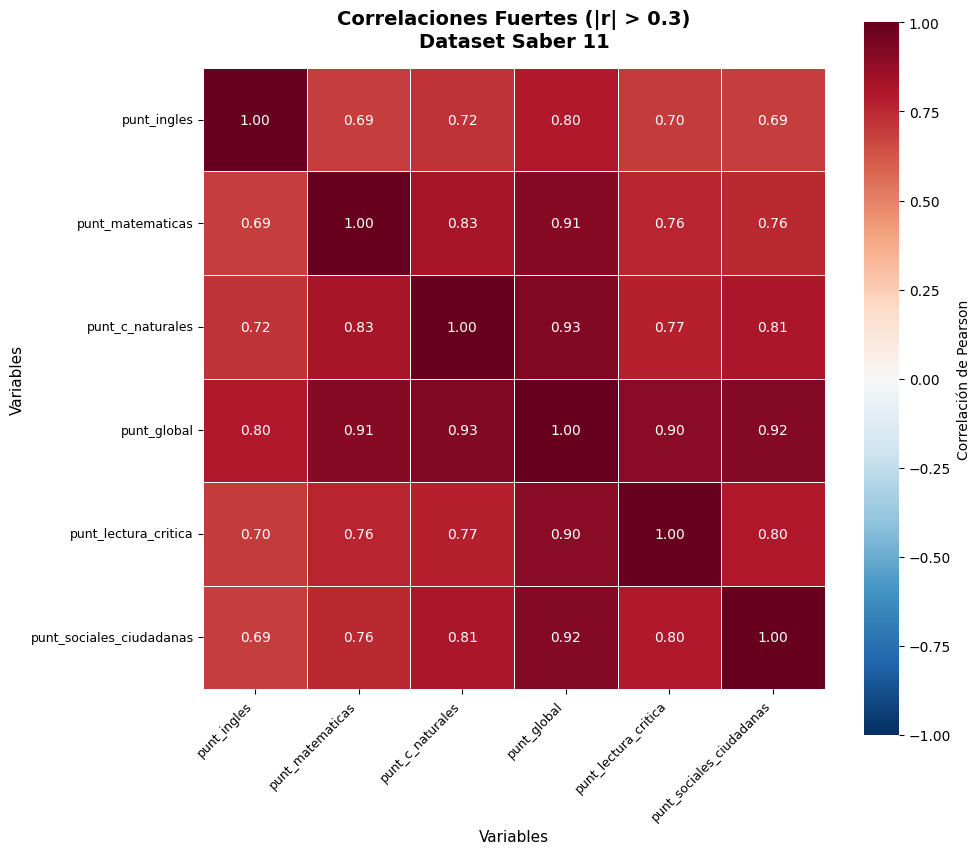


VARIABLES INCLUIDAS (6):
   1. punt_ingles
   2. punt_matematicas
   3. punt_c_naturales
   4. punt_global
   5. punt_lectura_critica
   6. punt_sociales_ciudadanas

✅ HEATMAP ENFOCADO GENERADO


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

print("="*70)
print("VISUALIZACIÓN DE CORRELACIONES SIGNIFICATIVAS")
print("="*70)

# Verifico que la matriz de correlación esté disponible
if 'df_corr_pd' not in globals():
    print("Error: Debe ejecutar primero la celda de análisis de correlación")
else:
    # Defino el umbral para correlaciones significativas
    THRESHOLD = 0.3
    
    print(f"\nUmbral de significancia: |r| > {THRESHOLD}")
    
    # Identifico variables con al menos una correlación significativa
    strong_vars = []
    corr_matrix = df_corr_pd.values
    
    for i, var in enumerate(df_corr_pd.columns):
        # Analizo correlaciones excluyendo la diagonal (correlación consigo misma = 1.0)
        correlations = corr_matrix[i, :]
        max_corr = np.max(np.abs(correlations[correlations < 0.99999]))
        
        if max_corr > THRESHOLD:
            strong_vars.append(var)
    
    print(f"Variables con correlación significativa identificadas: {len(strong_vars)}")
    
    if len(strong_vars) > 0:
        # Creo submatriz con solo las variables relevantes
        df_corr_subset = df_corr_pd.loc[strong_vars, strong_vars]
        
        # Calculo tamaño óptimo de figura
        n_vars = len(strong_vars)
        fig_size = min(max(10, n_vars * 0.8), 25)
        
        print(f"\nGenerando heatmap de {n_vars} × {n_vars} variables...")
        
        # Creación de la figura
        fig, ax = plt.subplots(figsize=(fig_size, fig_size))
        
        # Generación del heatmap
        sns.heatmap(
            df_corr_subset,
            annot=True if n_vars <= 15 else False,  # Anotaciones solo si hay pocas variables
            fmt='.2f',
            cmap='RdBu_r',  # Esquema de color divergente
            center=0,
            vmin=-1,
            vmax=1,
            square=True,
            linewidths=0.5,
            cbar_kws={'label': 'Correlación de Pearson', 'shrink': 0.8},
            ax=ax
        )
        
        plt.title(f'Matriz de Correlaciones Significativas (|r| > {THRESHOLD})\nDataset Saber 11 - Variables Numéricas', 
                  fontsize=14, fontweight='bold', pad=15)
        plt.xlabel('Variables', fontsize=11)
        plt.ylabel('Variables', fontsize=11)
        
        # Ajuste de etiquetas
        plt.xticks(rotation=45, ha='right', fontsize=9)
        plt.yticks(rotation=0, fontsize=9)
        
        plt.tight_layout()
        
        # Exportación de la visualización
        output_path = "datos/matriz_correlacion_significativas.png"
        plt.savefig(output_path, dpi=150, bbox_inches='tight')
        print(f"\nHeatmap exportado a: {output_path}")
        
        plt.show()
        
        # Listado de variables incluidas en la visualización
        print("\n" + "="*70)
        print(f"VARIABLES INCLUIDAS EN EL HEATMAP ({len(strong_vars)}):")
        print("="*70)
        for i, var in enumerate(strong_vars, 1):
            print(f"   {i:2d}. {var}")
        
        print("\n" + "="*70)
        print("INTERPRETACIÓN DEL HEATMAP:")
        print("="*70)
        print("Colores rojos: Correlaciones positivas (las variables aumentan juntas)")
        print("Colores azules: Correlaciones negativas (una aumenta cuando la otra disminuye)")
        print("Intensidad del color: Fuerza de la correlación (más intenso = más fuerte)")
        print("\nEsta visualización permite identificar:")
        print("   - Variables redundantes que aportan información similar")
        print("   - Posibles problemas de multicolinealidad para modelado")
        print("   - Relaciones naturales entre variables del dominio educativo")
        print("="*70)
    else:
        print(f"\nNo se encontraron variables con correlación superior a {THRESHOLD}")